# Yolo small

In [1]:
import torch
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image, ImageDraw
import requests

In [23]:
image = None

In [27]:
image = Image.open("example_1.jpg")

In [24]:
if image is None:
    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    image = Image.open(requests.get(url, stream=True).raw)

In [4]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-small')

/Users/vp/anaconda3/lib/python3.11/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [5]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

In [6]:
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

label: car
label: car


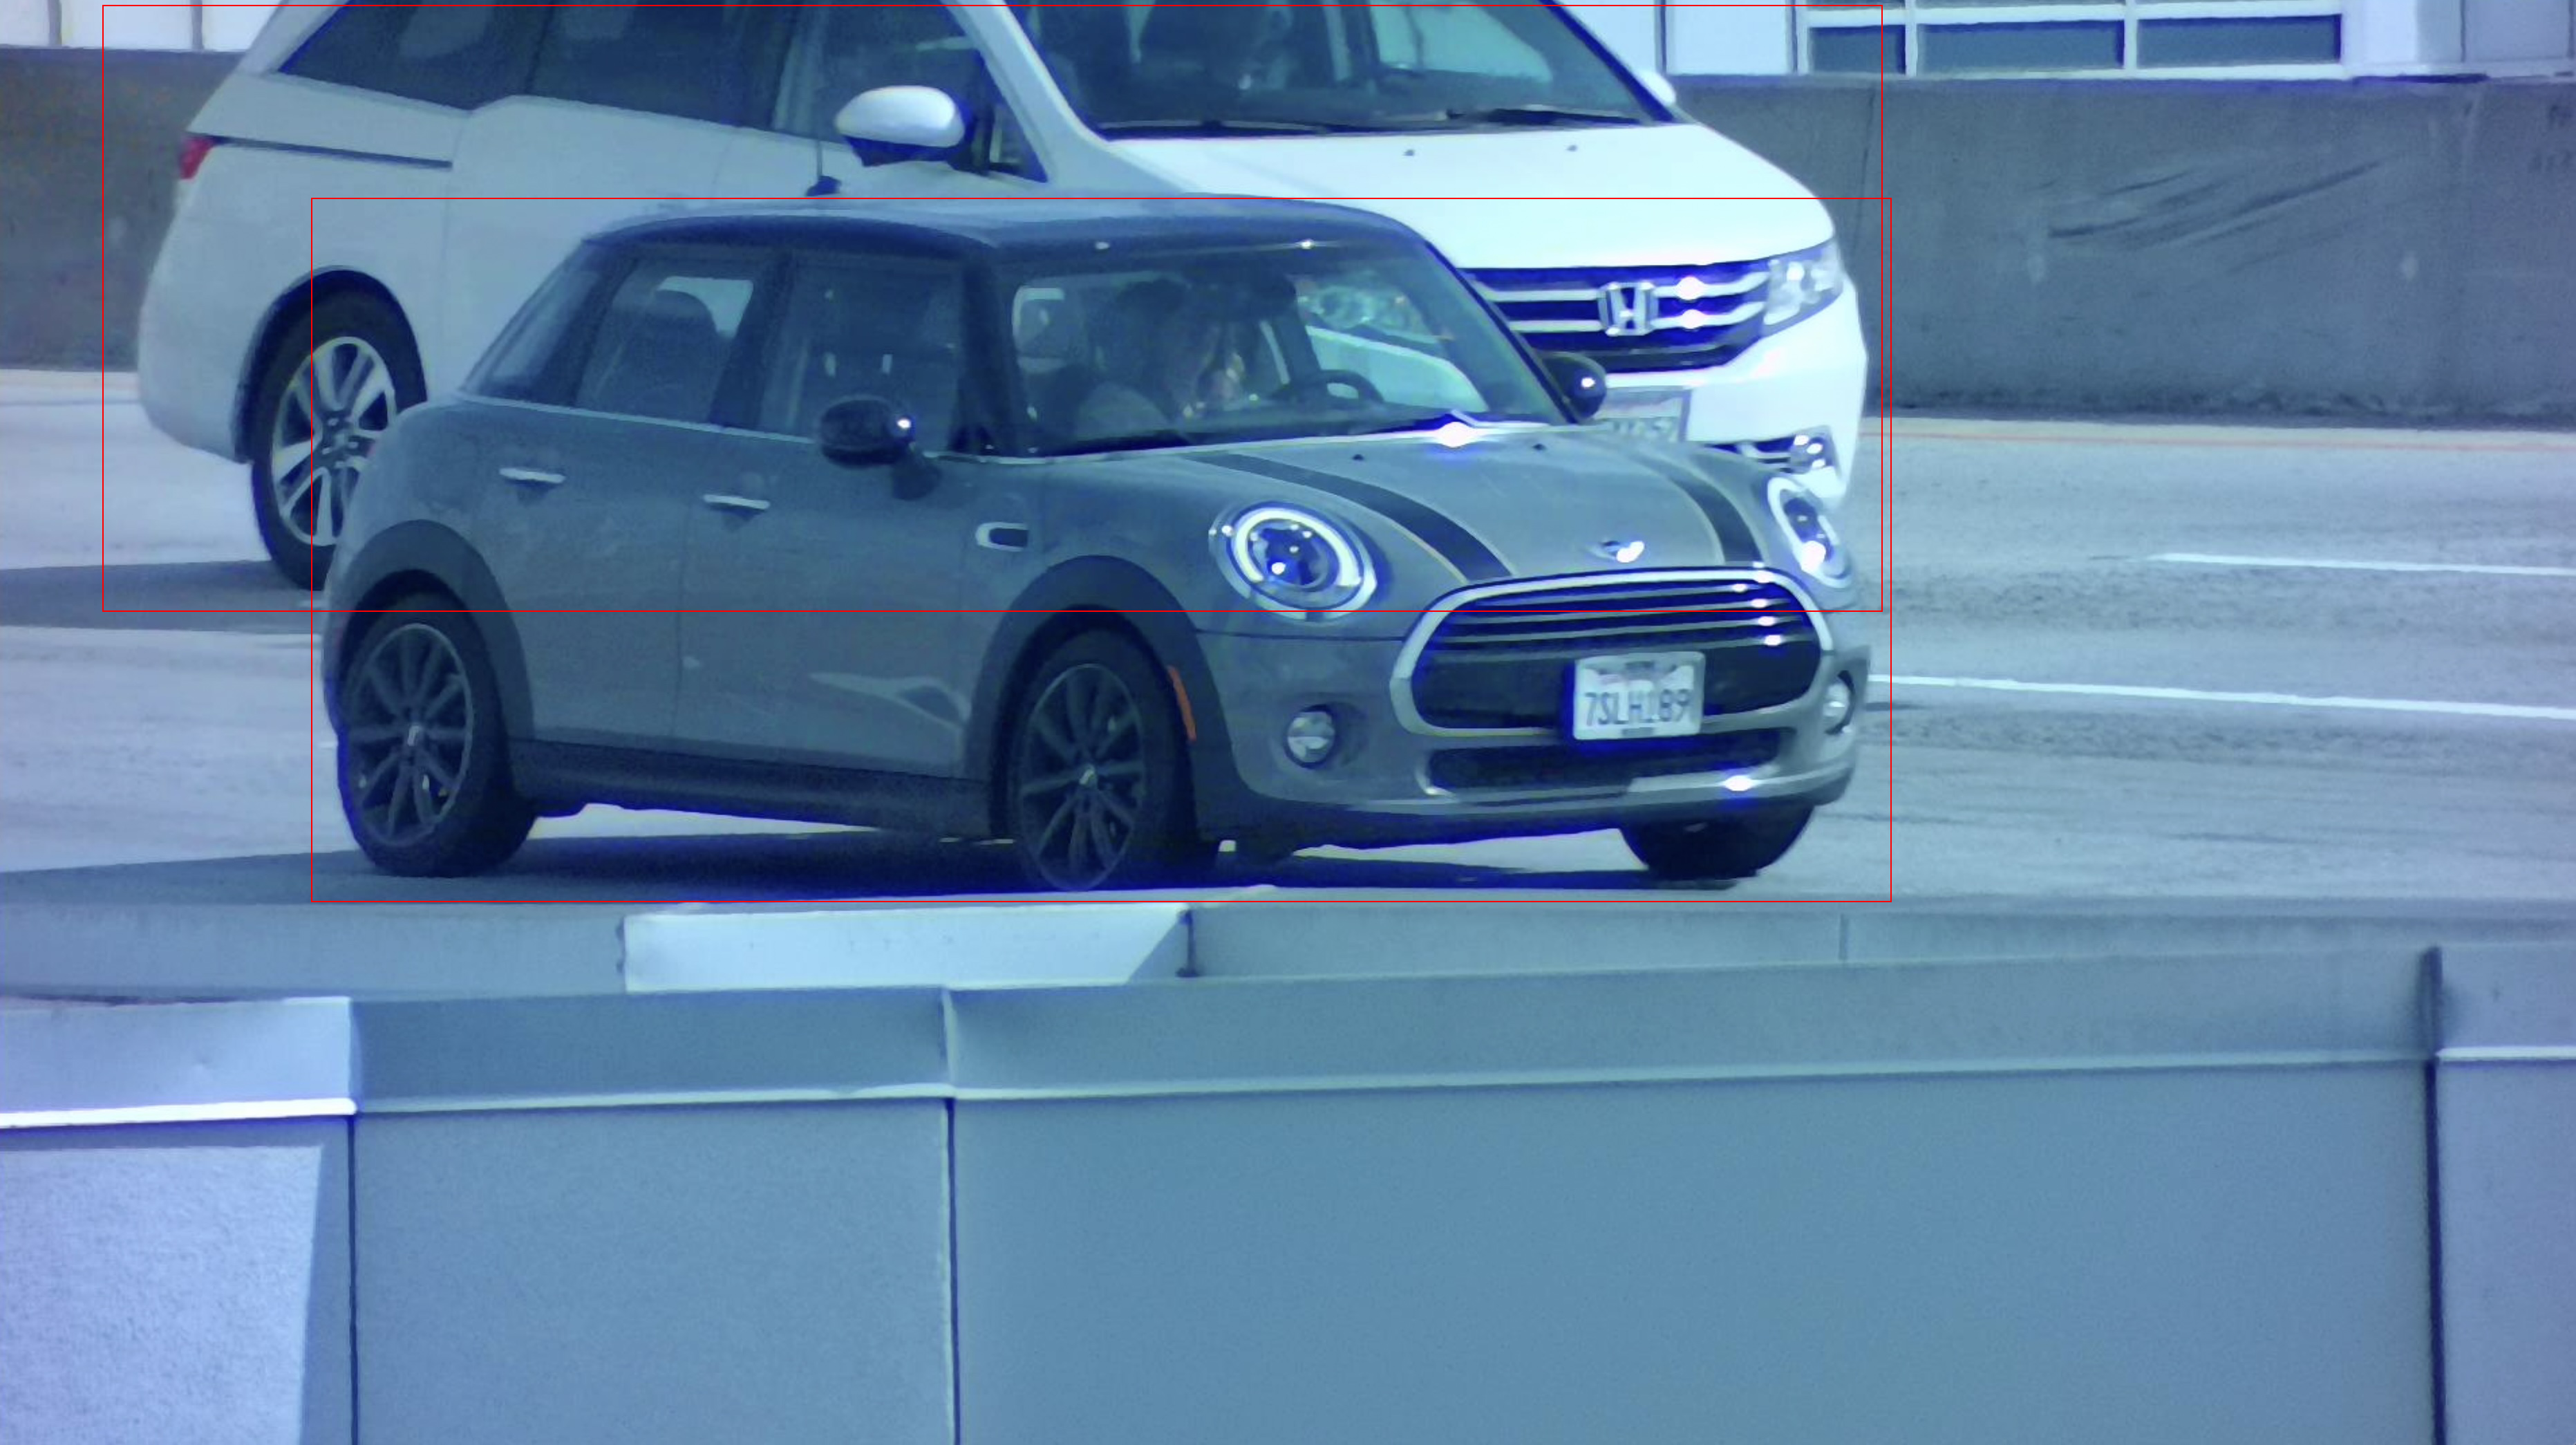

In [28]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes
w,h = image.size
probas = outputs.logits.softmax(-1)[0, :, :-1].cpu()
keep = probas.max(-1).values > 0.9


bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, 0:].cpu(), (w,h))
labels = model.config.id2label

draw = ImageDraw.Draw(image)
for index, bbox in enumerate(bboxes_scaled.tolist()):
    (xmin, ymin, xmax, ymax) = bbox
    labelid = probas[index].argmax()
    if not keep[index]:
        continue
    print("label: " + labels[int(labelid)])
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
image